## Toxicity Baseline NB
Competition location:  
https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification  
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

In [63]:
import numpy as np
import pandas as pd
import vocab as vocabulary
import collections
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from nltk.corpus import stopwords

### Load data

In [2]:
train = pd.read_csv('/data/ToxicityData/train.csv')
test = pd.read_csv('/data/ToxicityData/test.csv')

In [3]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [4]:
train.iloc[0]

id                                                                                 59848
target                                                                                 0
comment_text                           This is so cool. It's like, 'would you want yo...
severe_toxicity                                                                        0
obscene                                                                                0
identity_attack                                                                        0
insult                                                                                 0
threat                                                                                 0
asian                                                                                NaN
atheist                                                                              NaN
bisexual                                                                             NaN
black                

### Tokenization
This can be as simple as calling string.split() - good enough for English and many European languages - but we could also do something more sophisticated here. There are various types of tokenizers:  
  
1. nltk.tokenize.treebank import TreebankWordTokenizer
2. nltk.tokenize import WhitespaceTokenizer

In [5]:
from nltk.tokenize import WhitespaceTokenizer
white_token = WhitespaceTokenizer()

In [6]:
from keras.preprocessing.text import Tokenizer
keras_token = Tokenizer()

Using TensorFlow backend.


In [7]:
V = 30000
SEED = 23
VAL_SPLIT = 0.3

#### First, tokenize everything to build vocab
Only use vocabs from train data.

In [8]:
tokenize_all_one_list = white_token.tokenize(' '.join(train['comment_text'].tolist()))

In [9]:
len(set(tokenize_all_one_list))

1670966

There are 1.67 million tokens, do not have to use all of them as tokens

In [10]:
collections.Counter(tokenize_all_one_list).most_common(20)

[('the', 4261263),
 ('to', 2611234),
 ('and', 2096691),
 ('of', 2021781),
 ('a', 1880032),
 ('is', 1454734),
 ('in', 1294522),
 ('that', 1163635),
 ('for', 911179),
 ('I', 861783),
 ('you', 734810),
 ('are', 714218),
 ('be', 618319),
 ('not', 613791),
 ('have', 598834),
 ('it', 598509),
 ('on', 577471),
 ('with', 556536),
 ('as', 471924),
 ('they', 464629)]

In [11]:
collections.Counter(tokenize_all_one_list).most_common(V)[-1]

('astonished', 141)

#### The 30kth token has 140 appearances, not too bad, we will use top 30k covab, and leave the rest as unknown
This step takes a long time.

In [12]:
vocab = vocabulary.Vocabulary(tokenize_all_one_list, size=30000)

### Are there words that are more particular to spams?




### Conversion to IDs
While there are a few ML models that operate directly on strings, in most cases (and always for neural networks) you'll need to convert the tokens to integer IDs that can index into a feature vector. To do this, we'll need to keep track of a vocabulary, which in its simplest form is just a dictionary.  

And unlike before, we are now tokenizing every row and then turn them into IDs using our vocab created


In [13]:
x_train = [vocab.words_to_ids(white_token.tokenize(train_row)) for train_row in train['comment_text'].tolist()]
x_test = [vocab.words_to_ids(white_token.tokenize(test_row)) for test_row in test['comment_text'].tolist()]

In [14]:
train['comment_text'].tolist()[0]

"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"

In [15]:
vocab.ids_to_words(x_train[0])

['This',
 'is',
 'so',
 'cool.',
 "It's",
 'like,',
 '<unk>',
 'you',
 'want',
 'your',
 'mother',
 'to',
 'read',
 '<unk>',
 'Really',
 'great',
 'idea,',
 'well',
 'done!']

In [16]:
train[train['comment_text'].str.contains("need one down under")]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
149299,424798,0.6,"giant hickeys. need one down under, hahaha",0.0,0.3,0.0,0.1,0.0,NaN,NaN,...,143325,approved,0,0,0,0,0,0.6,0,10


In [17]:
train.iloc[0,2]

"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"

### Create Sparse input matrix
For many language models, we need to convert inputs into a sparse matrix.   
For example, for simple Naive Bayes BOW, we need to convert each sentence into an array containing the entire vocabulary. Each sentence would only have few words out of the entire vocab, so we will end up with a very sparse matrix, with each sentence being a row, and each row has V entries corresponding to the vocabulary.   
  
We have a function in utils to convert sentences into sparse matrix. In this representation, instead of printing V for each row, we only print the words that have a count > 0. 

In [18]:
y_train = np.array(train['target'] > 0.5)
y_train[:5]

array([False, False, False, False,  True])

In [19]:
y_train = [1 if i else 0 for i in y_train]
y_train[:5]

[0, 0, 0, 0, 1]

In [20]:
for ind, y in enumerate(y_train):
    print(y)
    if y == 1:
        print(ind)
        print(vocab.ids_to_words(x_train[ind]))
        break

0
0
0
0
1
4
['haha', 'you', 'guys', 'are', 'a', 'bunch', 'of', 'losers.']


In [21]:
train[train['comment_text'].str.contains("you guys are a bunch of")]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [22]:
rng = np.random.RandomState(SEED)

indices = np.arange(len(x_train))

rng.shuffle(indices)  # in-place

x_train =  np.array(x_train)
y_train =  np.array(y_train)
# the indices slicing only works with np array

x_train_s = x_train[indices]
y_train_s = y_train[indices]


split_idx = int(VAL_SPLIT * len(x_train))
val_x = x_train_s[:split_idx]
val_y = y_train_s[:split_idx]

train_x = x_train_s[split_idx:]
train_y  = y_train_s[split_idx:]



In [23]:
for ind, y in enumerate(train_y):
    if y == 1:
        print(ind)
        print(vocab.ids_to_words(train_x[ind]))
        break

20
['Its', 'more', 'like', '<unk>', 'row,', 'i', 'would', 'hate', 'to', 'be', 'a', 'business', 'owner', 'on', 'the', 'mall', 'it', 'used', 'to', 'be', 'so', 'cool,', 'not', 'anymore', 'you', '<unk>', 'even', 'see', 'any', 'cops', 'walking', 'around,', 'pathetic.']


In [24]:
train[train['comment_text'].str.contains("i would hate to be a")]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1522698,5984708,0.527027,"Its more like skid row, i would hate to be a b...",0.013514,0.013514,0.0,0.540541,0.0,NaN,NaN,...,379755,approved,0,0,0,2,0,0.0,0,74


In [25]:
for ind, y in enumerate(val_y):
    if y == 1:
        print(ind)
        print(vocab.ids_to_words(val_x[ind]))
        break

3
['Right!', 'And', 'our', 'federal', 'government', 'is', 'just', 'overrun', 'with', 'such', '<unk>', 'people', 'who', 'never', 'ever', '<unk>', 'When', 'more', 'than', 'half', 'of', 'US', 'States', 'recognize', 'the', 'medical', 'and', '<unk>', 'recreational', 'use', 'of', 'cannabis,', 'then', 'its', 'only', 'a', 'matter', 'of', 'time', 'before', 'the', 'criminal', 'abuse', 'of', 'US', 'citizens', 'will', 'end.', 'Cannabis', 'is', 'now', 'the', 'cash', 'cow', 'of', 'the', 'judicial', 'system', 'and', 'its', 'multiple', 'private', 'contractors,', 'such', 'as', 'prison', '<unk>', '<unk>', 'outdated', 'information', 'that', 'a', 'minority', 'hopes', 'that', 'with', 'repetition', 'will', 'come', 'true,', 'is', 'a', '<unk>', 'game.', '<unk>', 'in', 'the', '<unk>', 'year', 'old', '<unk>', '<unk>', 'propaganda', 'ignores', 'the', 'reality', 'of', 'the', 'benefits', 'and', 'safety', 'of', 'cannabis', 'that', 'has', 'been', 'proven', 'scientifically', 'over', 'and', 'over', 'again.', 'Even', '

In [26]:
train[train['comment_text'].str.contains("And our federal government is just")]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
414450,750418,0.833333,Right! And our federal government is just ove...,0.0,0.0,0.166667,0.833333,0.0,NaN,NaN,...,157210,approved,0,0,0,0,0,0.0,0,6


In [27]:
train_x_sb = utils.id_lists_to_sparse_bow(train_x, V)
val_x_sb = utils.id_lists_to_sparse_bow(val_x, V)

In [28]:
print(train_x_sb[0])

  (0, 2)	1
  (0, 3)	1
  (0, 7)	1
  (0, 9)	1
  (0, 15)	1
  (0, 19)	1
  (0, 49)	1
  (0, 743)	1
  (0, 1956)	1
  (0, 2130)	1
  (0, 3619)	1
  (0, 3901)	1
  (0, 14046)	1


In [29]:
print("Training set: x = {:s} sparse, y = {:s}".format(str(train_x_sb.shape), str(len(train_x))))
print("Test set:     x = {:s} sparse, y = {:s}".format(str(val_x_sb.shape),  str(len(val_x))))

Training set: x = (1263412, 30000) sparse, y = 1263412
Test set:     x = (541462, 30000) sparse, y = 541462


## Naive Bayes
NB is used for classification, we we are going to turn the target variable into binary variable. 
This is only for testing purpose. For final model we do need a predicted probability so NB is out of the question.

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb = MultinomialNB()

print(train_x_sb[3][(0, 5)])
print(train_y[3])
print(val_x_sb[3][(0, 6)])
print(val_y[3])
print(train_x_sb.shape[0])
nb.fit(train_x_sb, train_y)
y_pred_val = nb.predict(val_x_sb)


acc = accuracy_score(val_y, y_pred_val)
print("Accuracy on test set: {:.02%}".format(acc))

6
0
8
1
1263412
Accuracy on test set: 90.68%


In [40]:
print(train_x_sb[6000])

  (0, 2)	3
  (0, 4)	2
  (0, 5)	1
  (0, 10)	1
  (0, 17)	3
  (0, 20)	1
  (0, 40)	1
  (0, 102)	1
  (0, 295)	1
  (0, 321)	1
  (0, 340)	2
  (0, 418)	1
  (0, 468)	2
  (0, 829)	1
  (0, 1188)	1
  (0, 1376)	1
  (0, 1558)	2
  (0, 1705)	1
  (0, 1842)	1
  (0, 2460)	1
  (0, 2799)	1
  (0, 3631)	1
  (0, 4597)	1
  (0, 4728)	2
  (0, 4937)	1
  (0, 5285)	1
  (0, 6971)	1
  (0, 18528)	1
  (0, 19277)	1
  (0, 23291)	1


In [31]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(val_y, y_pred_val)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97248911 0.33133366]
recall: [0.92717888 0.57907497]
fscore: [0.94929363 0.42149651]
support: [509701  31761]


In [32]:
total = 0
for ind, val in enumerate(y_pred_val):
    if val != val_y[ind]:
        print(vocab.ids_to_words(val_x[ind]))
        print("pred", val, "actual", val_y[ind])
        total += 1
    if total > 5:
        break
    
    

['Right!', 'And', 'our', 'federal', 'government', 'is', 'just', 'overrun', 'with', 'such', '<unk>', 'people', 'who', 'never', 'ever', '<unk>', 'When', 'more', 'than', 'half', 'of', 'US', 'States', 'recognize', 'the', 'medical', 'and', '<unk>', 'recreational', 'use', 'of', 'cannabis,', 'then', 'its', 'only', 'a', 'matter', 'of', 'time', 'before', 'the', 'criminal', 'abuse', 'of', 'US', 'citizens', 'will', 'end.', 'Cannabis', 'is', 'now', 'the', 'cash', 'cow', 'of', 'the', 'judicial', 'system', 'and', 'its', 'multiple', 'private', 'contractors,', 'such', 'as', 'prison', '<unk>', '<unk>', 'outdated', 'information', 'that', 'a', 'minority', 'hopes', 'that', 'with', 'repetition', 'will', 'come', 'true,', 'is', 'a', '<unk>', 'game.', '<unk>', 'in', 'the', '<unk>', 'year', 'old', '<unk>', '<unk>', 'propaganda', 'ignores', 'the', 'reality', 'of', 'the', 'benefits', 'and', 'safety', 'of', 'cannabis', 'that', 'has', 'been', 'proven', 'scientifically', 'over', 'and', 'over', 'again.', 'Even', 'th

In [33]:
train[train['comment_text'].str.contains("a small mind that can't")]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1438345,5877421,0.833333,"Mr. Eyman, it's a small mind that can't get on...",0.0,0.0,0.166667,0.833333,0.0,0.0,0.0,...,372947,approved,2,0,0,4,1,0.0,10,6


### Canonicalization
Depending on the application, we might want to do some pre-processing to remove spurious variation in the text. For example, we might want to lowercase words to avoid storing separate features for "I" and "i", and we might want to replace numbers with a special token rather than keep track of every possible value.

utils have a basic transformation in utils.canonicalize_word. It's important to write different one for different tasks since the use of language can be quite different

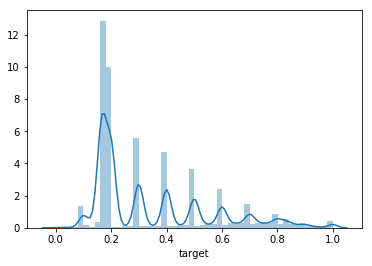

In [34]:
sns.distplot(train[train['target']!= 0].target)

### Some thoughts:
1. Many political comments, tend to get 'insult' when it comes to political comment
2. Many political comments can seem insulting to one person but not so insulting. These are the ones that are harder to predict
3. Many of the target values are below 0.5. And a lot of them are around 0.2. So the choice of 0.5 could be quite arbitrary.  It would be interesting to look at some of the lower ones.

In [35]:

i = 0

for ind, y in enumerate(train.target.tolist()):

    if 0.1< y < 0.25:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

39
Pity the menu lost so much vegan food! The Mash Tun was a favorite beer bar for all the delicious tempeh stuff.
Excited the staff is still there, can't wait to try the new beers.
id                                                                                239625
target                                                                          0.166667
comment_text                           Pity the menu lost so much vegan food! The Mas...
severe_toxicity                                                                        0
obscene                                                                                0
identity_attack                                                                        0
insult                                                                                 0
threat                                                                          0.166667
asian                                                                                NaN
atheist          

## having < 0.3 probably means only 1 annotator finds this offensive. Probably means it is not very offensive.

In [36]:

i = 0

for ind, y in enumerate(train.target.tolist()):

    if 0.25< y < 0.5:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

6
hahahahahahahahhha suck it.
id                                                             59861
target                                                      0.457627
comment_text                             hahahahahahahahhha suck it.
severe_toxicity                                            0.0508475
obscene                                                     0.305085
identity_attack                                                    0
insult                                                      0.254237
threat                                                             0
asian                                                            NaN
atheist                                                          NaN
bisexual                                                         NaN
black                                                            NaN
buddhist                                                         NaN
christian                                                        NaN
fema

In [42]:
nb.coef_.shape

(1, 30000)

In [58]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
# modified to work with current set up

def get_most_important_features(vocab, model, n=5):
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(np.exp(el), vocab.ids_to_words([i])) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes



In [59]:
importance = get_most_important_features(vocab, nb, 10)

In [60]:
importance

{0: {'bottom': [(3.0132208076154914e-07, ['Wally']),
   (3.0132208076154914e-07, ['philosophies']),
   (3.0132208076154914e-07, ['reconciliation.']),
   (3.0132208076154914e-07, ['Church’s']),
   (3.0132208076154914e-07, ['"can\'t']),
   (3.0132208076154914e-07, ['Apple,']),
   (3.0132208076154914e-07, ['marketable']),
   (3.0132208076154914e-07, ['F35']),
   (3.0132208076154914e-07, ['coding']),
   (3.0132208076154914e-07, ['bills?'])],
  'tops': [(0.010993736116585117, ['you']),
   (0.011302591249365715, ['that']),
   (0.011689187478982776, ['in']),
   (0.017024998885108278, ['is']),
   (0.019854714545539987, ['of']),
   (0.022295122077627783, ['a']),
   (0.02371284246761088, ['and']),
   (0.025669025415914846, ['to']),
   (0.040037568837029316, ['the']),
   (0.08021495111953202, ['<unk>'])]}}

In [61]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Non-Toxic', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Toxic', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()




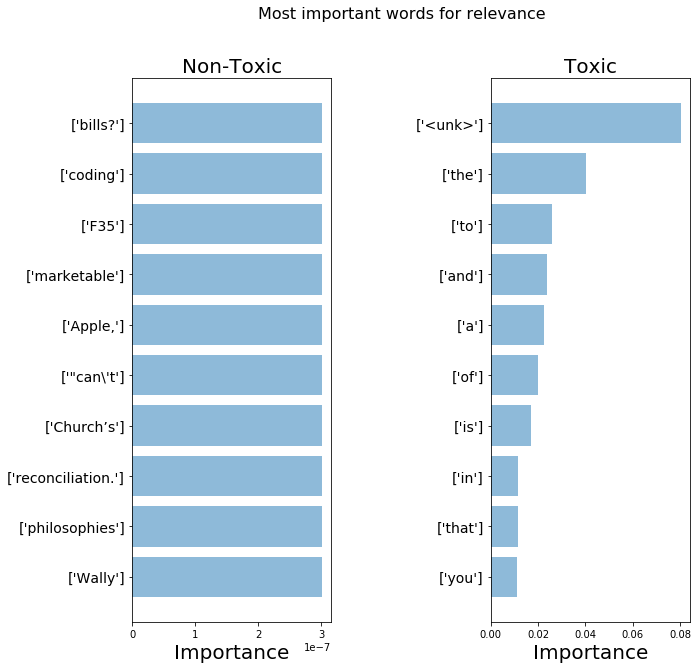

In [62]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## conclusion:
We need much better word parsing and feature selection!
Putting things all in unknown is not fair, maybe build vocab based in toxic words

## remove stop words
https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

In [ ]:


def check_frequency(data = alldate_toxicity['comment_text'], n = 20):
    stop = stopwords.words('english')
    data  = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()[:n]
    return freq

top_10_toxicity_othertime = check_frequency(data = alldate_toxicity[alldate_toxicity['created_date'] != '2017-01-01']['comment_text'], n = 10)
top_10_toxicity_jan_2017 = check_frequency(data = jan_2017_toxicity['comment_text'], n = 10)